## Data exploration notebook

#### Access data from Blob, load it to a dataframe and perform some data operations and visualization
###### Note : Ensure you have install pip packages before running this notebook (pip install -r requirements.txt)
###### Note : Ensure you have signed in to Azure CLI, can be achieved by executing "az login --use-device-code" in seperate terminal.

In [1]:
"""
Fetch Azure login. 
Ensure you are signed in, can be achieved by executing "az login --use-device-code" in seperate terminal.
"""
print("############ ENSURE YOU HAVE SIGNED IN PRIO TO RUNNING THIS NOTEBOOK!")
print("If not configured in the environment, execute this in a terminal if not already done : 'az login --use-device-code'")
from azure.identity import DefaultAzureCredential
credential = DefaultAzureCredential()

############ ENSURE YOU HAVE SIGNED IN PRIO TO RUNNING THIS NOTEBOOK!
If not configured in the environment, execute this in a terminal if not already done : 'az login --use-device-code'


In [2]:
"""
Get the SubscriptionID
"""
from azure.identity import DefaultAzureCredential
from azure.mgmt.subscription import SubscriptionClient

# Setup credentials and client
credential = DefaultAzureCredential()
client = SubscriptionClient(credential)

# Get the list of subscriptions
subscriptions = client.subscriptions.list()

# Print subscription details
subscriptionList = []
for subscription in subscriptions:
    subscriptionList.append({"subscription_id": subscription.subscription_id, "display_name": subscription.display_name})
if len(subscriptionList) > 0:
    print("Subscriptions found: " + str(len(subscriptionList)))
else:
    print("No subscriptions found.")


Subscriptions found: 1


In [3]:
"""
Get the StorageAccount
"""
from azure.identity import DefaultAzureCredential
from azure.mgmt.storage import StorageManagementClient

# Set up credentials and client
credential = DefaultAzureCredential()
subscriptionId = subscriptionList[0]["subscription_id"]
storage_client = StorageManagementClient(credential, subscriptionId)

# Get the list of storage accounts
storage_accounts = storage_client.storage_accounts.list()

storageAccountsList = []
# Print the storage account names
for account in storage_accounts:
    resourceGroup = str(account.id).split('/')[4]
    storageAccountsList.append({"name": account.name, "resourceGroup": resourceGroup, "environment": account.tags['environment'], "location": account.location})
if len(storageAccountsList) > 0:
    print("Storage accounts found: " + str(len(storageAccountsList)))
else:
    print("No storage accounts found")

Storage accounts found: 1


In [4]:
""" 
List the containers in the StorageAccount
"""
from azure.storage.blob import BlobServiceClient
staccName = storageAccountsList[0]["name"]
account_url = "https://"+staccName+".blob.core.windows.net"
# Create the BlobServiceClient object
blob_service_client = BlobServiceClient(account_url, credential=credential)

containers = blob_service_client.list_containers(include_metadata=True)
containersList = []
for container in containers:
    containersList.append({"name": container["name"]})
if len(containersList) > 0:
    print("Blob Storage Containers found: " + str(len(containersList)))
else:
    print("No Blob Storage Containers found")

Blob Storage Containers found: 3


In [5]:
### Create Blob Access
import subprocess
import json
from azure.identity import ClientSecretCredential 
import time,os
subscriptionId = subscriptionList[0]["subscription_id"]
resourceGroup = storageAccountsList[0]["resourceGroup"]

# Execute the Azure CLI command
credFileName = "credentials.json"
command = 'az ad sp create-for-rbac --role="Storage Blob Data Contributor" --scopes="/subscriptions/{}" > {}'.format(subscriptionId,credFileName)
os.system(command)
with open(credFileName, "r") as file:
    blobCred = json.load(file)

# Extract necessary values
CONT_CLIENT_ID = blobCred["appId"]
CONT_CLIENT_SECRET = blobCred["password"]
CONT_TENANT_ID = blobCred["tenant"]

blobCredential = ClientSecretCredential(
    tenant_id=CONT_TENANT_ID,
    client_id=CONT_CLIENT_ID,
    client_secret=CONT_CLIENT_SECRET,
)
time.sleep(5)
print("Blob Credential created")

Blob Credential created


In [7]:
from azure.storage.blob import BlobServiceClient
import polars as pl
from pathlib import Path
import pyarrow

# This will use the managed identity when run on Azure services that support it
staccName = storageAccountsList[0]["name"]
account_url = "https://"+staccName+".blob.core.windows.net"
tempDir = "tmp/fromBlobStorage"
containerName = "mocked-curated"

blob_service_client = BlobServiceClient(account_url, credential=blobCredential)
containerClient = blob_service_client.get_container_client(container=containerName)
blobList = containerClient.list_blobs()
print("List of blobs fetched, starting iteration.")
for blob in blobList:
    # Check if the blob is a .parquet file
    if blob.name.endswith('.parquet'):
        #print(f"Downloading {blob.name} to local storage...")
        blob_client = containerClient.get_blob_client(blob=blob.name)
        
        local_file_path = os.path.join(tempDir, blob.name)

        # Ensure directories exist
        Path(os.path.dirname(local_file_path)).mkdir(parents=True, exist_ok=True)

        with open(local_file_path, "wb") as f:
            data = blob_client.download_blob()
            data.readinto(f)

df = pl.read_parquet(
    source=tempDir,
    use_pyarrow=True
    )

df.head()

List of blobs fetched, starting iteration.


priority,category,assignee,reporter,status,description,Open_Timestamp,Closed_Timestamp,Minutes_To_Close,Open_Year,Open_Month,Open_Day
str,str,str,str,str,str,datetime[μs],datetime[μs],f64,cat,cat,cat
"""Medium""","""Network""","""User1""","""Reporter5""","""Resolved""","""I have issues …",2022-10-01 12:59:10.045808,2022-10-11 12:59:10.045808,14400.0,"""2022""","""10""","""1"""
"""Critical""","""Network""","""User2""","""Reporter1""","""Rejected""","""I have issues …",2022-10-01 12:59:10.058385,2022-10-03 12:59:10.058385,2880.0,"""2022""","""10""","""1"""
"""Medium""","""Software""","""User3""","""Reporter3""","""Closed""","""I have issues …",2022-10-01 12:59:10.059659,2022-10-02 12:59:10.059659,1440.0,"""2022""","""10""","""1"""
"""Medium""","""Access""","""User1""","""Reporter4""","""Resolved""","""I have issues …",2022-10-01 12:59:10.062338,2022-10-09 12:59:10.062338,11520.0,"""2022""","""10""","""1"""
"""Medium""","""Network""","""User2""","""Reporter3""","""Resolved""","""I have issues …",2022-10-01 12:59:10.064648,2022-10-04 12:59:10.064648,4320.0,"""2022""","""10""","""1"""


In [8]:
import polars as pl

# Extract date from datetime column
dfAnalytics = df

# Group by "category" and "Minutes_To_Close" and count
grouped = dfAnalytics.group_by(["category"]).agg(pl.count("category").alias("count"))
print(grouped)

agg_df = df.group_by('category').agg([
    pl.col('Minutes_To_Close').sum().alias('Total_Minutes')
])
print(agg_df)

# Extract the lists
categories = agg_df['category'].to_list()
totalMinutes = agg_df['Total_Minutes'].to_list()

shape: (4, 2)
┌──────────┬───────┐
│ category ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ Network  ┆ 33458 │
│ Access   ┆ 16483 │
│ Security ┆ 16768 │
│ Software ┆ 16866 │
└──────────┴───────┘
shape: (4, 2)
┌──────────┬───────────────┐
│ category ┆ Total_Minutes │
│ ---      ┆ ---           │
│ str      ┆ f64           │
╞══════════╪═══════════════╡
│ Access   ┆ 1.3011264e8   │
│ Network  ┆ 2.6519472e8   │
│ Software ┆ 1.3343616e8   │
│ Security ┆ 1.3278096e8   │
└──────────┴───────────────┘


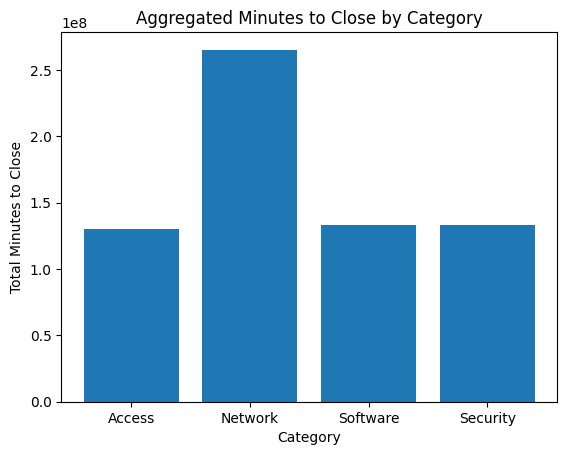

In [9]:
import matplotlib.pyplot as plt

# Plotting a bar chart
plt.bar(categories, totalMinutes)
plt.xlabel('Category')
plt.ylabel('Total Minutes to Close')
plt.title('Aggregated Minutes to Close by Category')
plt.show()

In [12]:
# Extracting year, month, and day
dfAnalytics = df
pl.Config.set_tbl_cols(20) #Config for amount of columns to display
dfAnalytics.head() # Display the head of the dataframe

priority,category,assignee,reporter,status,description,Open_Timestamp,Closed_Timestamp,Minutes_To_Close,Open_Year,Open_Month,Open_Day
str,str,str,str,str,str,datetime[μs],datetime[μs],f64,cat,cat,cat
"""Medium""","""Network""","""User1""","""Reporter5""","""Resolved""","""I have issues …",2022-10-01 12:59:10.045808,2022-10-11 12:59:10.045808,14400.0,"""2022""","""10""","""1"""
"""Critical""","""Network""","""User2""","""Reporter1""","""Rejected""","""I have issues …",2022-10-01 12:59:10.058385,2022-10-03 12:59:10.058385,2880.0,"""2022""","""10""","""1"""
"""Medium""","""Software""","""User3""","""Reporter3""","""Closed""","""I have issues …",2022-10-01 12:59:10.059659,2022-10-02 12:59:10.059659,1440.0,"""2022""","""10""","""1"""
"""Medium""","""Access""","""User1""","""Reporter4""","""Resolved""","""I have issues …",2022-10-01 12:59:10.062338,2022-10-09 12:59:10.062338,11520.0,"""2022""","""10""","""1"""
"""Medium""","""Network""","""User2""","""Reporter3""","""Resolved""","""I have issues …",2022-10-01 12:59:10.064648,2022-10-04 12:59:10.064648,4320.0,"""2022""","""10""","""1"""


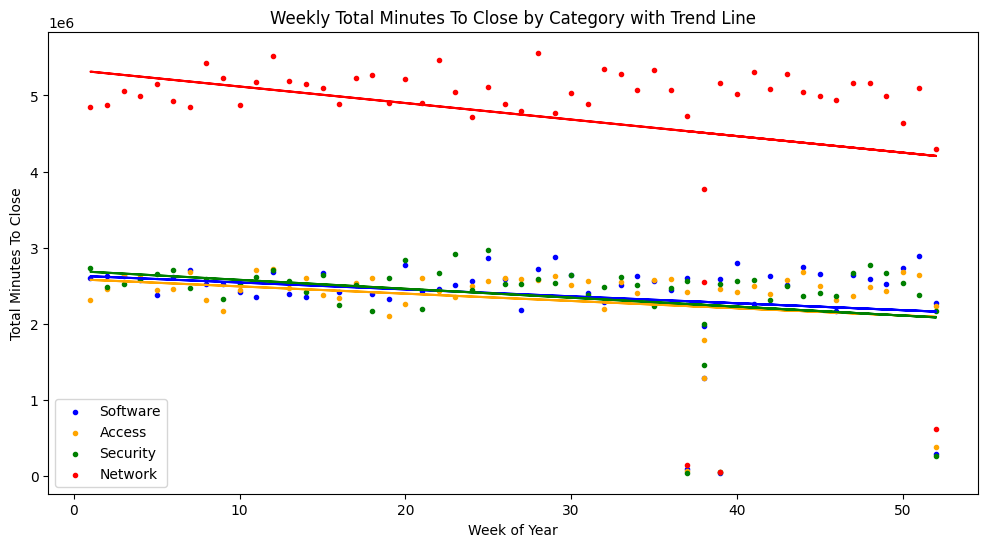

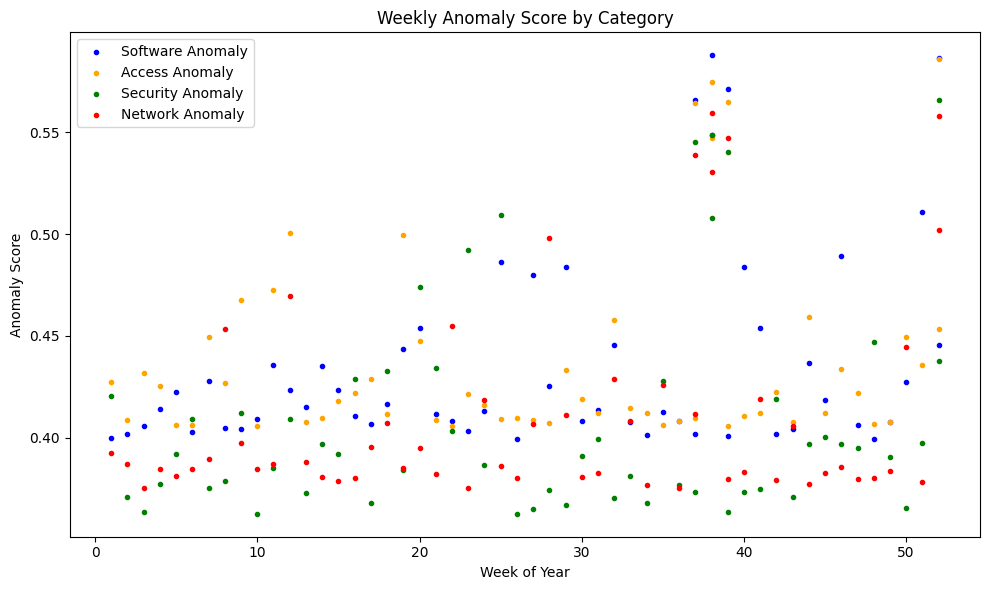

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Extract week and year using .dt accessor
dfAnalytics = dfAnalytics.with_columns([
    dfAnalytics["Closed_Timestamp"].dt.year().alias("Year"),
    dfAnalytics["Closed_Timestamp"].dt.week().alias("Week")
])

# Group by Year, Week, and category and sum the minutes
agg_df = dfAnalytics.group_by(["Year", "Week", "category"]).agg([
    pl.col("Minutes_To_Close").sum().alias("Total_Minutes")
])

# Sort by Year and Week
agg_df = agg_df.sort(by=["Year", "Week"])

# Convert aggregated dataframe to Pandas for plotting
agg_pd = agg_df.to_pandas()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red']  # you can customize these colors as needed
for idx, category in enumerate(agg_pd["category"].unique()):
    subset = agg_pd[agg_pd["category"] == category]
    
    # Scatter plot
    ax.scatter(subset["Week"], subset["Total_Minutes"], marker='.', color=colors[idx], label=category)
    
    # Trend line
    z = np.polyfit(subset["Week"], subset["Total_Minutes"], 1)
    p = np.poly1d(z)
    ax.plot(subset["Week"], p(subset["Week"]), linestyle="-", color=colors[idx])

    ### Plot Anomaly scores
    clf = IsolationForest(contamination=0.1)
    clf.fit(subset[["Total_Minutes"]])
    scores = clf.decision_function(subset[["Total_Minutes"]])
    anomaly_scores = 0.5 - scores / 2  # normalize scores to [0, 1] range
    ax2.scatter(subset["Week"], anomaly_scores, marker='.', color=colors[idx], label=f"{category} Anomaly")

ax.set_xlabel("Week of Year")
ax.set_ylabel("Total Minutes To Close")
ax.set_title("Weekly Total Minutes To Close by Category with Trend Line")
ax.legend()
plt.tight_layout()

ax2.set_xlabel("Week of Year")
ax2.set_ylabel("Anomaly Score")
ax2.set_title("Weekly Anomaly Score by Category")
ax2.legend()
plt.tight_layout()

plt.show()
